<a href="https://colab.research.google.com/github/kuds/rl-lunar-lander/blob/main/%5BLunar%20Lander%5D%20Proximal%20Policy%20Optimization%20(PPO).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proximal Policy Optimization (PPO)
---
In this notebook, you will implement a PPO agent with Gymansium's LunarLander-v3 environment.

In [1]:
!pip install swig

In [2]:
!pip install stable_baselines3 gymnasium[box2d]

In [3]:
import gymnasium
import stable_baselines3
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.vec_env import VecFrameStack, VecTransposeImage
from stable_baselines3.common.vec_env import VecVideoRecorder

import os
import torch
import numpy
import scipy
import platform
import IPython
import matplotlib
import matplotlib.pyplot
from importlib.metadata import version

In [4]:
print(f"Python Version: {platform.python_version()}")
print(f"Torch Version: {version('torch')}")
print(f"Is Cuda Available: {torch.cuda.is_available()}")
print(f"Cuda Version: {torch.version.cuda}")
print(f"Gymnasium Version: {version('gymnasium')}")
print(f"Numpy Version: {version('numpy')}")
print(f"Scipy Version: {version('scipy')}")
print(f"Swig Version: {version('swig')}")
print(f"Stable Baselines3 Version: {version('stable_baselines3')}")
print(f"IPython Version: {version('ipython')}")

Python Version: 3.11.12
Torch Version: 2.6.0+cu124
Is Cuda Available: True
Cuda Version: 12.4
Gymnasium Version: 1.1.1
Numpy Version: 2.0.2
Scipy Version: 1.15.3
Swig Version: 4.3.1
Stable Baselines3 Version: 2.6.0
IPython Version: 7.34.0


In [5]:
rl_type = "PPO"
env_str = "LunarLander-v3"
log_dir = "./logs/{}".format(env_str)
name_prefix = "lunar_lander"

In [6]:
env = gymnasium.make(env_str)
print("Observation Space Size: ", env.observation_space.shape)
print('Actions Space: ', env.action_space)
env.close()

Observation Space Size:  (8,)
Actions Space:  Discrete(4)


<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type swigvarlink has no __module__ attribute


In [7]:
#Create Training Environment
env = make_vec_env(env_str, n_envs=1)

#Create Elevation Environment
env_val = make_vec_env(env_str, n_envs=1)

eval_callback = EvalCallback(env_val,
                             best_model_save_path=log_dir,
                             log_path=log_dir,
                             eval_freq=25_000,
                             render=False,
                             deterministic=True,
                             n_eval_episodes=20)

# Initialize PPO
model = PPO('MlpPolicy', env, verbose=0, ent_coef=0.005)

# Train the model
model.learn(total_timesteps=500_000,
            progress_bar=True,
            callback=eval_callback)

# Save the model
model.save(os.path.join(log_dir, "final_model"))

mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=20)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

env.close()
env_val.close()

Output()

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Eval num_timesteps=25000, episode_reward=-742.38 +/- 355.25

Episode length: 436.05 +/- 124.87

New best mean reward!

Eval num_timesteps=50000, episode_reward=-1068.02 +/- 593.12

Episode length: 354.85 +/- 80.30

Eval num_timesteps=75000, episode_reward=-65.91 +/- 24.63

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=100000, episode_reward=85.02 +/- 73.42

Episode length: 891.65 +/- 149.31

New best mean reward!

Eval num_timesteps=125000, episode_reward=-40.27 +/- 26.10

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=150000, episode_reward=-12.36 +/- 85.53

Episode length: 870.65 +/- 167.93

Eval num_timesteps=175000, episode_reward=39.72 +/- 120.83

Episode length: 679.40 +/- 191.70

Eval num_timesteps=200000, episode_reward=26.05 +/- 114.68

Episode length: 671.35 +/- 180.96

Eval num_timesteps=225000, episode_reward=65.62 +/- 135.02

Episode length: 657.45 +/- 232.70

Eval num_timesteps=250000, episode_reward=152.74 +/- 103.51

Episode length: 519.80 +/- 203.63

New best mean reward!

Eval num_timesteps=275000, episode_reward=122.33 +/- 122.12

Episode length: 501.90 +/- 182.22

Eval num_timesteps=300000, episode_reward=163.82 +/- 107.04

Episode length: 422.85 +/- 78.87

New best mean reward!

Eval num_timesteps=325000, episode_reward=180.84 +/- 92.66

Episode length: 404.25 +/- 72.60

New best mean reward!

Eval num_timesteps=350000, episode_reward=229.59 +/- 26.79

Episode length: 401.65 +/- 48.13

New best mean reward!

Eval num_timesteps=375000, episode_reward=149.33 +/- 124.82

Episode length: 372.25 +/- 117.94

Eval num_timesteps=400000, episode_reward=194.71 +/- 92.45

Episode length: 341.00 +/- 155.47

Eval num_timesteps=425000, episode_reward=206.31 +/- 97.28

Episode length: 347.80 +/- 151.11

Eval num_timesteps=450000, episode_reward=175.12 +/- 107.48

Episode length: 331.30 +/- 62.97

Eval num_timesteps=475000, episode_reward=196.37 +/- 101.18

Episode length: 285.95 +/- 63.77

Eval num_timesteps=500000, episode_reward=188.33 +/- 104.17

Episode length: 342.80 +/- 158.39

Mean reward: 141.33 +/- 116.21


In [8]:
# Create Elevation environment
env = make_vec_env(env_str, n_envs=1, seed=0)

# Load the best model
best_model_path = os.path.join(log_dir, "best_model.zip")
best_model = PPO.load(best_model_path, env=env)

mean_reward, std_reward = evaluate_policy(best_model, env, n_eval_episodes=20)
print(f"Best Model - Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Record video of the best model playing Lunar Lander
best_model_file_name = "best_model_{}".format(name_prefix)
env = VecVideoRecorder(env,
                       log_dir,
                       video_length=5000,
                       record_video_trigger=lambda x: x == 0,
                       name_prefix=best_model_file_name)

obs = env.reset()
for _ in range(5000):
    action, _states = best_model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()
    if dones:
      break

env.close()

Best Model - Mean reward: 149.38 +/- 119.02


/usr/local/lib/python3.11/dist-packages/moviepy/config_defaults.py:1: DeprecationWarning: invalid escape sequence '\P'
  """


Moviepy - Building video /content/logs/LunarLander-v3/best_model_lunar_lander-step-0-to-step-5000.mp4.
Moviepy - Writing video /content/logs/LunarLander-v3/best_model_lunar_lander-step-0-to-step-5000.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/LunarLander-v3/best_model_lunar_lander-step-0-to-step-5000.mp4


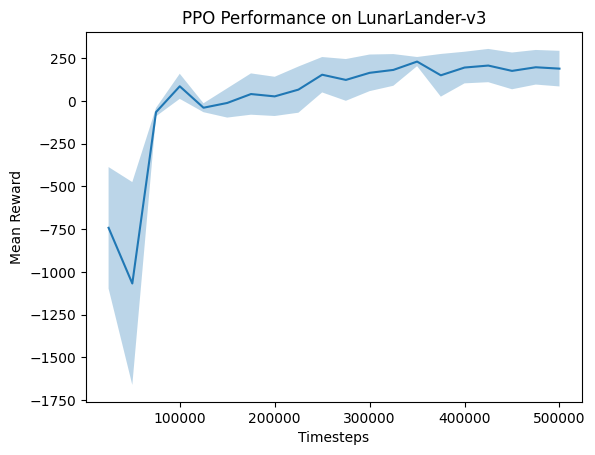

In [9]:
# Load the evaluations.npz file
data = numpy.load(os.path.join(log_dir, "evaluations.npz"))

# Extract the relevant data
timesteps = data['timesteps']
results = data['results']

# Calculate the mean and standard deviation of the results
mean_results = numpy.mean(results, axis=1)
std_results = numpy.std(results, axis=1)

# Plot the results
matplotlib.pyplot.figure()
matplotlib.pyplot.plot(timesteps, mean_results)
matplotlib.pyplot.fill_between(timesteps,
                               mean_results - std_results,
                               mean_results + std_results,
                               alpha=0.3)

matplotlib.pyplot.xlabel('Timesteps')
matplotlib.pyplot.ylabel('Mean Reward')
matplotlib.pyplot.title(f"{rl_type} Performance on {env_str}")
matplotlib.pyplot.show()

In [10]:
rl_type = "PPO"
env_str = "LunarLanderContinuous-v3"
log_dir = "./logs/{}".format(env_str)
name_prefix = "lunar_lander_continuous"

In [11]:
env = gymnasium.make(env_str)
print("Observation Space Size: ", env.observation_space.shape)
print("Action Space Size: ", env.action_space.shape)
env.close()

Observation Space Size:  (8,)
Action Space Size:  (2,)


In [12]:
#Create Training Environment)
env = make_vec_env(env_str, n_envs=1)

#Create Elevation Environment
env_val = make_vec_env(env_str, n_envs=1)

eval_callback = EvalCallback(env_val,
                             best_model_save_path=log_dir,
                             log_path=log_dir,
                             eval_freq=25_000,
                             render=False,
                             n_eval_episodes=20)

# Initialize PPO
model = PPO('MlpPolicy', env, verbose=0, ent_coef=0.005)

# Train the model
model.learn(total_timesteps=500_000,
            progress_bar=True,
            callback=eval_callback)

# Save the model
model.save(os.path.join(log_dir, "final_model"))

mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=20)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

env.close()
env_val.close()

Output()

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Eval num_timesteps=25000, episode_reward=-180.05 +/- 39.32

Episode length: 183.40 +/- 85.51

New best mean reward!

Eval num_timesteps=50000, episode_reward=-26.20 +/- 108.28

Episode length: 577.50 +/- 269.39

New best mean reward!

Eval num_timesteps=75000, episode_reward=-27.50 +/- 27.93

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=100000, episode_reward=-73.27 +/- 77.25

Episode length: 872.80 +/- 185.48

Eval num_timesteps=125000, episode_reward=41.43 +/- 101.23

Episode length: 927.75 +/- 98.10

New best mean reward!

Eval num_timesteps=150000, episode_reward=165.38 +/- 61.63

Episode length: 674.45 +/- 98.38

New best mean reward!

Eval num_timesteps=175000, episode_reward=106.12 +/- 100.92

Episode length: 573.00 +/- 119.41

Eval num_timesteps=200000, episode_reward=134.22 +/- 106.83

Episode length: 510.30 +/- 96.60

Eval num_timesteps=225000, episode_reward=147.05 +/- 96.04

Episode length: 438.70 +/- 114.38

Eval num_timesteps=250000, episode_reward=101.66 +/- 141.32

Episode length: 345.60 +/- 122.82

Eval num_timesteps=275000, episode_reward=107.24 +/- 130.57

Episode length: 393.90 +/- 219.28

Eval num_timesteps=300000, episode_reward=128.17 +/- 107.04

Episode length: 349.85 +/- 79.38

Eval num_timesteps=325000, episode_reward=131.98 +/- 115.50

Episode length: 410.50 +/- 157.20

Eval num_timesteps=350000, episode_reward=181.14 +/- 84.14

Episode length: 388.40 +/- 185.95

New best mean reward!

Eval num_timesteps=375000, episode_reward=200.62 +/- 81.98

Episode length: 322.90 +/- 54.90

New best mean reward!

Eval num_timesteps=400000, episode_reward=191.37 +/- 94.51

Episode length: 367.25 +/- 100.60

Eval num_timesteps=425000, episode_reward=201.23 +/- 53.29

Episode length: 377.05 +/- 73.81

New best mean reward!

Eval num_timesteps=450000, episode_reward=179.77 +/- 94.51

Episode length: 338.50 +/- 93.47

Eval num_timesteps=475000, episode_reward=139.94 +/- 119.77

Episode length: 321.55 +/- 77.32

Eval num_timesteps=500000, episode_reward=192.93 +/- 96.68

Episode length: 294.90 +/- 72.23

Mean reward: 137.74 +/- 121.16


In [13]:
# Create Elevation environment
env = make_vec_env(env_str, n_envs=1, seed=0)

# Load the best model
best_model_path = os.path.join(log_dir, "best_model.zip")
best_model = PPO.load(best_model_path, env=env)

mean_reward, std_reward = evaluate_policy(best_model, env, n_eval_episodes=20)
print(f"Best Model - Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Record video of the best model playing Lunar Lander
best_model_file_name = "best_model_{}".format(name_prefix)
env = VecVideoRecorder(env,
                       log_dir,
                       video_length=5000,
                       record_video_trigger=lambda x: x == 0,
                       name_prefix=best_model_file_name)

obs = env.reset()
for _ in range(5000):
    action, _states = best_model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()
    if dones:
      break

env.close()

Best Model - Mean reward: 197.28 +/- 71.11
Moviepy - Building video /content/logs/LunarLanderContinuous-v3/best_model_lunar_lander_continuous-step-0-to-step-5000.mp4.
Moviepy - Writing video /content/logs/LunarLanderContinuous-v3/best_model_lunar_lander_continuous-step-0-to-step-5000.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/LunarLanderContinuous-v3/best_model_lunar_lander_continuous-step-0-to-step-5000.mp4


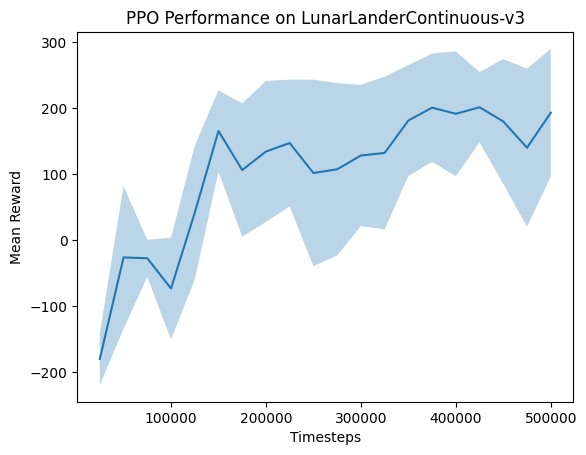

In [14]:
# Load the evaluations.npz file
data = numpy.load(os.path.join(log_dir, "evaluations.npz"))

# Extract the relevant data
timesteps = data['timesteps']
results = data['results']

# Calculate the mean and standard deviation of the results
mean_results = numpy.mean(results, axis=1)
std_results = numpy.std(results, axis=1)

# Plot the results
matplotlib.pyplot.figure()
matplotlib.pyplot.plot(timesteps, mean_results)
matplotlib.pyplot.fill_between(timesteps,
                               mean_results - std_results,
                               mean_results + std_results,
                               alpha=0.3)

matplotlib.pyplot.xlabel('Timesteps')
matplotlib.pyplot.ylabel('Mean Reward')
matplotlib.pyplot.title(f"{rl_type} Performance on {env_str}")
matplotlib.pyplot.show()